# 実践コンピュータビジョン

[実践 コンピュータビジョン](https://www.oreilly.co.jp/books/9784873116075/)  

演習ノート

# 2. 画像の局所記述子

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pathlib import Path    
import sys
sys.path.append("../")
from impro import impro,detection

## 2.1 Harrisコーナー記述子
### 1.2.1 画像と点を表示する

$I_x$、$I_y$をそれぞれx方向の微分、y方向の微分として次のような行列$M_I$を考える
$$
M_I=\begin{pmatrix}
I_x^2 & I_xI_y \\
I_xI_y & I_y^2 
\end{pmatrix}
$$

周辺ピクセルの影響も考えるため、ガウスフィルター$W$を畳み込む
$$
\overline{M_I}=W*M_I
$$
この$\overline{M_I}$の2つの固有値の大きさでコーナーを検出できる。  

#### なぜこれでコーナーが検出できるのか

ペンシルベニア州立大学コンピューターサイエンス学科の講義資料を参照

[Lecture 06: Corner Detection](https://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf)

#### コーナーとは

コーナーとは、明度$I(x,y)$が直交する2つの方向に移動したときに大きく変化する場所である。

明度の変化は次のように表せる
$$
E(u,v)=\sum_{x,y}{w(x,y)[I(x+u,y+v)-I(x,y)]^2}
$$

#### テイラー展開
テイラー展開によって2次元関数は次のように近似できる。$u$、$v$は微少だとする。
$$
f(x+u,y+v)=f(x,y)+uf_x+vf_y
$$

これを上に用いれば
$$
\begin{align}
[I(x+u,y+v)-I(x,y)]^2
&=[uI_x+vI_y]^2\\
&=u^2I_x^2+2uvI_xI_y+v^2I_y^2\\
&=
\begin{pmatrix}
u&v
\end{pmatrix}
\begin{pmatrix}
I_x^2 & I_xI_y \\
I_xI_y & I_y^2 
\end{pmatrix}
\begin{pmatrix}
u\\v
\end{pmatrix}\\
&=
\begin{pmatrix}
u&v
\end{pmatrix}
M_I
\begin{pmatrix}
u\\v
\end{pmatrix}
\end{align}
$$

#### 二次形式
↑の議論から若干飛躍してしまうが、明度変化$E$は次のように表せる。$M$は$M_I$と同様対称行列である。
$$
E(u,v)=\begin{pmatrix}
u&v
\end{pmatrix}
M
\begin{pmatrix}
u\\v
\end{pmatrix}
$$

これは二次形式である。二次形式についてはここを参照  
[二次形式の意味，微分，標準形など](https://manabitimes.jp/math/1240)

↑のサイトにも書いてある通り、対称行列は直交行列で対角化可能である。つまり$M$は直交行列$U$で
$$
UMU^T=
\begin{pmatrix}
\lambda_1 & 0 \\
0 & \lambda_2 \\
\end{pmatrix}
$$
と2つの固有値が対角に並んだ行列に対角化できる。  
つまり$\boldsymbol{x}=(u\ v)$で、$\boldsymbol{X}=U\boldsymbol{x}$と座標変換すると、
$$
\begin{align}
\boldsymbol{x}^TM\boldsymbol{x}&=
\boldsymbol{X}^T
\begin{pmatrix}
\lambda_1 & 0 \\
0 & \lambda_2 \\
\end{pmatrix}
\boldsymbol{X}\\
&=\sum_i{\lambda_iX_i^2}
\end{align}
$$

#### Harrisコーナー検出
つまり、元の座標から、$\boldsymbol{X}=U\boldsymbol{x}$と座標変換すれば、明度変化$E$は次のようになる。
$$
E(u,v)=\sum_i{\lambda_iX_i^2}
$$
これは$X_1$という方向に離れると$\lambda_1$だけ、そしてそれに直交する$X_2$という方向に離れると$\lambda_2$だけ明度が変化することを表す。  
よって2つの固有値$\lambda_1$と$\lambda_2$がどちらも大きい場合にコーナーと判断する。

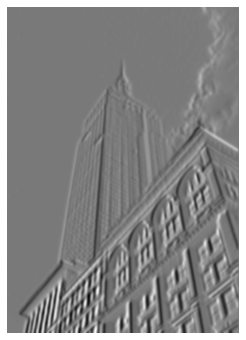

In [17]:
from scipy import ndimage

sigma=3
# 画像を読み込む
im_path=Path("resources/sample_images/empire.jpg")
im=cv2.imread(str(im_path))
im_gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
imx=ndimage.gaussian_filter(im_gray,(sigma,sigma),(0,1),float)
impro.imshow(imx,show_mode="scale")

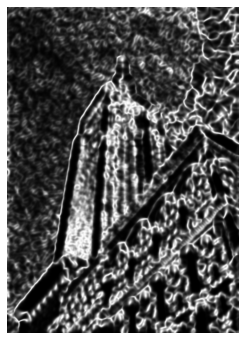

In [26]:
impro.imshow(harrisim,show_mode="scale")

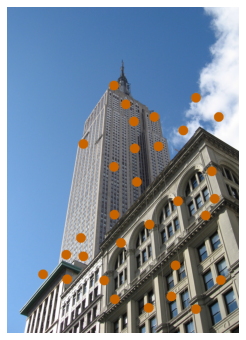

In [24]:
harrisim=detection.compute_harris_response(im_gray,sigma=3)
coords=detection.search_harris_point(harrisim,min_dist=40,threshold=0.999)
detection.plot_harris_points(im,coords)

### 疑問
なんかハリス値と画像がずれてないか？  
→透明にして重ねてみる